# Deep Learning vs Traditional ML (Logistic Regression) Camprison Notebook

Now that we have trained various LTSM with up to 2 million samples on Google Colab, we are going to compare the results with our traditional ML model (Logistic Regression)

We know that Logistic Regression's performance plateaus after about 200k samples and we know that LSTM is not performing as well as Logistic Regression with only 200k samples. 2 million is around the limit where we can use Google Colab to train our models while still working within the 24 hour backend limit. Further training for LSTM will probably have to be done on GCP using one of the GPU based compute instances.

We will take the results that we have so far to see if it's worth our while to keep training LSTM with more examples on GCP

All deep learning models use:
* Glove embedding with 300 dimension vectors
    * keep stop words
    * did not lemmatize words
    * remove all HTML tags
    * punchuations are removed
    * contractions are expanded
* max sequence length of 100 words (this is same as what we've been doing)



## Traditional ML Model

* Model: Logistic Regression
* Class weights: balanced
* Features: TF-IDF with 4k features
    * remove top words
    * lemmatize words
    * remove all HTML tags
    * punchuations are removed
    * contractions are expanded
* Sample Size: 50k to 9mil

## LSTM Models

| Name | LSTM Units | Spatial Droput between Embedding and LSTM Layer | LSTM Dropout | Sample Size |
|------|--------------|-------------------------------------------------|--------------|-----------|
| LSTMB32 (No Dropout) | 32 | 20% | N/A | 200k to 1mil |
| LSTMB16 (No Dropout) | 16 | 20% | N/A | 200k to 1mil |
| LSTMB16 (Removed All Dropouts) | 16 | N/A | N/A | 200k to 1mil |
| LSTMb64 | 64 | 20% | 20% | 200k to 2mil |
| LSTMB64 (No Dropout) | 64 | 20% | N/A | 200k to 1mil |
| LSTMB128 | 128 | N/A | 0.2 (recurrant) | 50k to 500k |

* Embeding Size: 300
* Early Stop Patience: 4
* Epoch: Up to 20

    
# Conclusion

LSTM with less than 128 cells did not do as well as Logistic Regression model. When we increased LSTM cells to 128, we start seeing the performance of the model exceed logistic regression after 

Starting with just 100k samples, we are seeing LSTM outperform it's Logistic Regression counter part in our custom metric.

When we look closer at the classification report, we are s




In [1]:
# import sibling utilities
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import importlib

import util.dict_util as du
import util.report_util as ru
import util.plot_util as pu

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set(font_scale=2)


/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load PySpark LR Report

In [2]:
# load report file form all of our deep learning models
REPORT_DIR = "../reports"
REPORT_LR = f'{REPORT_DIR}/201911-pyspark-report.csv'


report_lr = pd.read_csv(REPORT_LR, quotechar="'")
# flatten out classification report so we can graph later
report_lr = ru.convert_dnn_report_format(report_lr)

# calculate our custom score
report_lr["eval_metric"] = report_lr.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))


## Load results from LSTM network with various architectures

In [22]:
# LSTMB128
report_lstmb128_dr0_rdr20_batch32 = pd.read_csv(f'{REPORT_DIR}/glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv', quotechar="'")
report_lstmb128_dr0_rdr20_batch32 = report_lstmb128_dr0_rdr20_batch32[(report_lstmb128_dr0_rdr20_batch32.model_name == "LSTMB128") & (report_lstmb128_dr0_rdr20_batch32.feature_set_name == "glove_with_stop_nonlemmatized")]
report_lstmb128_dr0_rdr20_batch32 = ru.convert_dnn_report_format(report_lstmb128_dr0_rdr20_batch32)
report_lstmb128_dr0_rdr20_batch32["eval_metric"] = report_lstmb128_dr0_rdr20_batch32.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))

# LSTM16
report_lstmb16_2 = pd.read_csv(f'{REPORT_DIR}/LSTM16-glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv', quotechar="'")
# report_lstmb16_2 = report_lstmb16_2[(report_lstmb16_2.model_name == "LSTMB16") & (report_lstmb16_2.feature_set_name == "glove_with_stop_nonlemmatized")]
report_lstmb16_2 = ru.convert_dnn_report_format(report_lstmb16_2)
report_lstmb16_2["eval_metric"] = report_lstmb16_2.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))

# LSTM16_DR20_RDR20_BATCH128
report_lstmb16_dr20_rdr20_batch128 = pd.read_csv(f'{REPORT_DIR}/LSTM16-dr20-rdr20-batch128-glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv', quotechar="'")
report_lstmb16_dr20_rdr20_batch128 = ru.convert_dnn_report_format(report_lstmb16_dr20_rdr20_batch128)
report_lstmb16_dr20_rdr20_batch128["eval_metric"] = report_lstmb16_dr20_rdr20_batch128.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))

# LSTM128_DR0_RDR0_BATCH128_LR01
report_lstmb128_dr0_rdr0_batch128 = pd.read_csv(f'{REPORT_DIR}/LSTM128_dr0_rdr0_batch128-glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv', quotechar="'")
report_lstmb128_dr0_rdr0_batch128 = ru.convert_dnn_report_format(report_lstmb128_dr0_rdr0_batch128)
report_lstmb128_dr0_rdr0_batch128["eval_metric"] = report_lstmb128_dr0_rdr0_batch128.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))

# LSTM128_DR20_RDR20_BATCH128_LR01
report_lstmb128_dr20_rdr20_batch128_lr01 = pd.read_csv(f'{REPORT_DIR}/LSTM128_dr20_rdr20_batch128-glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv', quotechar="'")
report_lstmb128_dr20_rdr20_batch128_lr01 = ru.convert_dnn_report_format(report_lstmb128_dr20_rdr20_batch128_lr01)
report_lstmb128_dr20_rdr20_batch128_lr01["eval_metric"] = report_lstmb128_dr20_rdr20_batch128_lr01.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))

# LSTM128_DR20_RDR20_BATCH128_LR001
report_lstmb128_dr20_rdr20_batch128_lr001 = pd.read_csv(f'{REPORT_DIR}/LSTM128_dr20_rdr20_batch128_lr001-glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv', quotechar="'")
report_lstmb128_dr20_rdr20_batch128_lr001 = ru.convert_dnn_report_format(report_lstmb128_dr20_rdr20_batch128_lr001)
report_lstmb128_dr20_rdr20_batch128_lr001["eval_metric"] = report_lstmb128_dr20_rdr20_batch128_lr001.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))

# LSTM128_DR20_RDR20_BATCH32_LR001
report_lstmb128_dr20_rdr20_batch32_lr001 = pd.read_csv(f'{REPORT_DIR}/LSTM128_dr20_rdr20_batch32_lr001-glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv', quotechar="'")
report_lstmb128_dr20_rdr20_batch32_lr001 = ru.convert_dnn_report_format(report_lstmb128_dr20_rdr20_batch32_lr001)
report_lstmb128_dr20_rdr20_batch32_lr001["eval_metric"] = report_lstmb128_dr20_rdr20_batch32_lr001.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))



# Model Accuracy

Accuracy = Number of Correct Predictions / Total Number of Predictions

When looking at accuracy, our small LSTM models actually performed better than LR as well as LSTM with 128 cells. However, this is misleading since these models tends to predict results into majority class and does not take into account behavior for minority classes since our sample distribution skews heavily towards 5-star reviews.

We want to look at more granular metric that takes into account recall and precision for various classes to get a better sense of how the models are doing

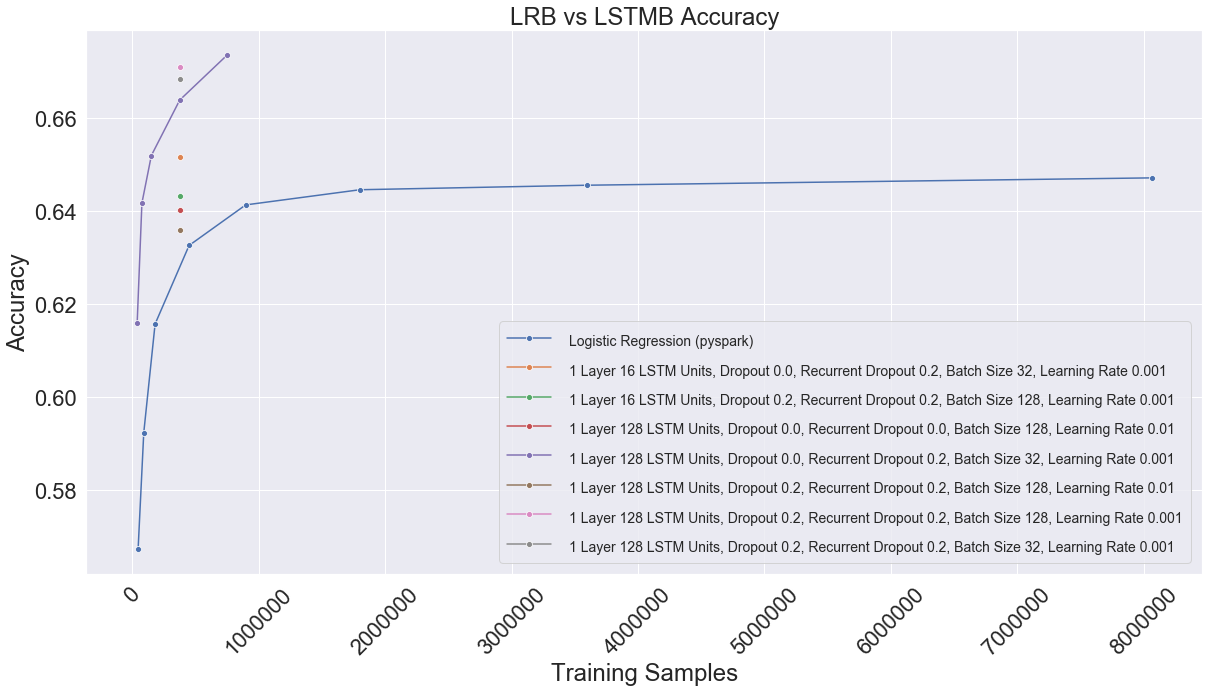

In [23]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=report_lr, x="train_examples", y="accuracy", marker="o", label="Logistic Regression (pyspark)")
sns.lineplot(data=report_lstmb16_2, x="train_examples", y="accuracy", marker="o", label=report_lstmb16_2.description.values[0])
sns.lineplot(data=report_lstmb16_dr20_rdr20_batch128, x="train_examples", y="accuracy", marker="o", label=report_lstmb16_dr20_rdr20_batch128.description.values[0])
sns.lineplot(data=report_lstmb128_dr0_rdr0_batch128, x="train_examples", y="accuracy", marker="o", label=report_lstmb128_dr0_rdr0_batch128.description.values[0])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch32, x="train_examples", y="accuracy", marker="o", label=report_lstmb128_dr0_rdr20_batch32.description.values[0])
sns.lineplot(data=report_lstmb128_dr20_rdr20_batch128_lr01, x="train_examples", y="accuracy", marker="o", label=report_lstmb128_dr20_rdr20_batch128_lr01.description.values[0])
sns.lineplot(data=report_lstmb128_dr20_rdr20_batch128_lr001, x="train_examples", y="accuracy", marker="o", label=report_lstmb128_dr20_rdr20_batch128_lr001.description.values[0])
sns.lineplot(data=report_lstmb128_dr20_rdr20_batch32_lr001, x="train_examples", y="accuracy", marker="o", label=report_lstmb128_dr20_rdr20_batch32_lr001.description.values[0])


_ = plt.xticks(rotation=45)
_ = plt.xlabel("Training Samples")
_ = plt.ylabel("Accuracy")
_ = plt.title("LRB vs LSTMB Accuracy")
_ = plt.setp(a.get_legend().get_texts(), fontsize='14')




# Custom Metric

Initial runs of our model tells us that precision and recall for 1-star and 5-star reviews are generally high. However, minority classes (2, 3, 4) generally has low recall.

We want the custom metric to take this into account and help us identify models that balances between precision for majority classes and increase recall for minority classes.

We define our custom metric as the harmonic mean of 1-star precision, 2-star recall, 3-star recall, 4-star recall, and 5-star precision

Once we take these into account, you see that LSTM start out performing roughly the same as Logistic Regression with 128 cells. However, it quickly out performs all models with only 500k samples.

* 128 cell networks did better than 16 cell networks
* 


In [5]:
report_lr.description

0    review_body-tfidf-df_none-ngram13-49784-4254-n...
1    review_body-tfidf-df_none-ngram13-99567-4159-n...
2    review_body-tfidf-df_none-ngram13-199134-4082-...
3    review_body-tfidf-df_none-ngram13-497835-4107-...
4    review_body-tfidf-df_none-ngram13-995688-4073-...
5    review_body-tfidf-df_none-ngram13-2000000-4068...
6    review_body-tfidf-df_none-ngram13-4000000-4062...
7    review_body-tfidf-df_none-ngram13-8960802-4068...
Name: description, dtype: object

In [6]:
report_lstmb128_dr20_rdr20_batch128_lr01.description

0    1 Layer 128 LSTM Units, Dropout 0.2, Recurrent...
Name: description, dtype: object

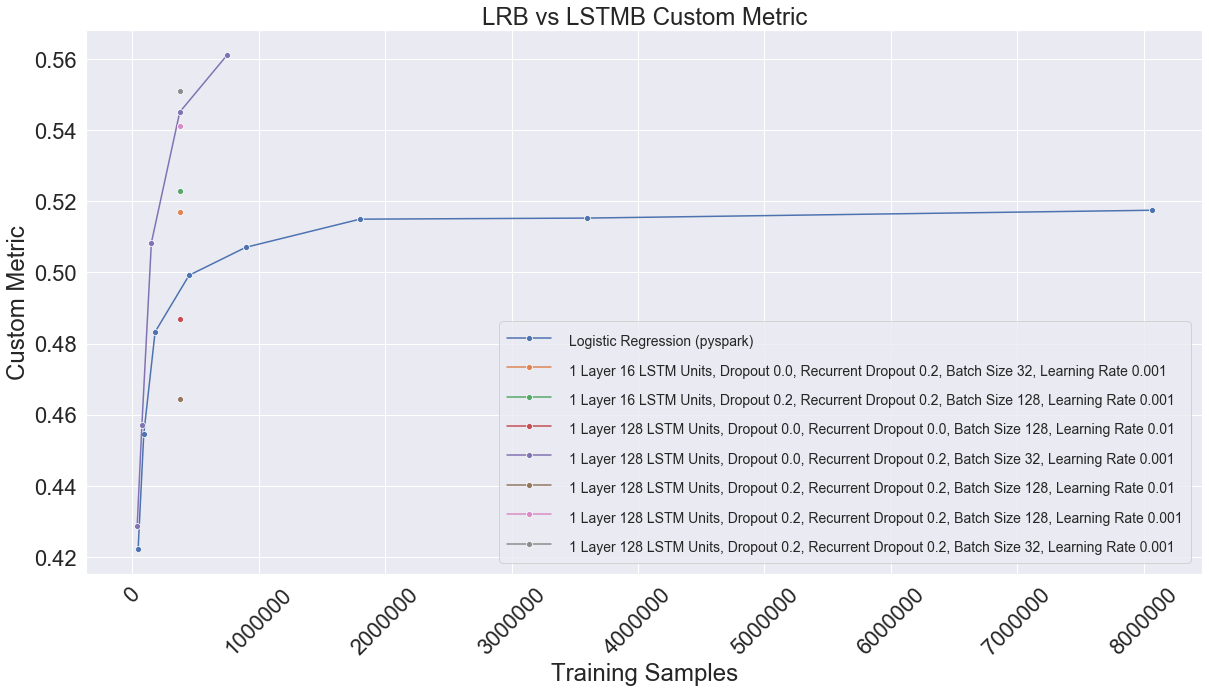

In [24]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=report_lr, x="train_examples", y="eval_metric", marker="o", label="Logistic Regression (pyspark)")
sns.lineplot(data=report_lstmb16_2, x="train_examples", y="eval_metric", marker="o", label=report_lstmb16_2.description.values[0])
sns.lineplot(data=report_lstmb16_dr20_rdr20_batch128, x="train_examples", y="eval_metric", marker="o", label=report_lstmb16_dr20_rdr20_batch128.description.values[0])
sns.lineplot(data=report_lstmb128_dr0_rdr0_batch128, x="train_examples", y="eval_metric", marker="o", label=report_lstmb128_dr0_rdr0_batch128.description.values[0])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch32, x="train_examples", y="eval_metric", marker="o", label=report_lstmb128_dr0_rdr20_batch32.description.values[0])
sns.lineplot(data=report_lstmb128_dr20_rdr20_batch128_lr01, x="train_examples", y="eval_metric", marker="o", label=report_lstmb128_dr20_rdr20_batch128_lr01.description.values[0])
sns.lineplot(data=report_lstmb128_dr20_rdr20_batch128_lr001, x="train_examples", y="eval_metric", marker="o", label=report_lstmb128_dr20_rdr20_batch128_lr001.description.values[0])
sns.lineplot(data=report_lstmb128_dr20_rdr20_batch32_lr001, x="train_examples", y="eval_metric", marker="o", label=report_lstmb128_dr20_rdr20_batch32_lr001.description.values[0])

_ = plt.xticks(rotation=45)
_ = plt.xlabel("Training Samples")
_ = plt.ylabel("Custom Metric")
_ = plt.title("LRB vs LSTMB Custom Metric")
_ = plt.setp(a.get_legend().get_texts(), fontsize='14')



# Compare Classification Between Logistic Regression (9 mil) and LSTM with 128 Cells (1 mil)

REMINDER: we are using precision for 1-star and 5-star, and recall for 2-star, 3-star, and 4-star reviews to calculate our custom metric. Tradtionally, we have seen that increasing 2-star recall has been challenging, mostly because we have the least amount of samples available to use for training in this category

* F1 and Precision for LSTM exceeds Logistic Regression for all star ratings
* Recall for LSTM for all star ratings exceed Logistic Regression with the exception of 1-star rating
* Generally, we see precison and recall for all star ratings increase for LSTM as we add more training examples
    * Only exception where we see a recall decline is 1-star ratings after 200k examples
    * Starting at around 500k samples for LSTMB, we are seeing 2-star review recall exceeding 3-star and 4-star recall that we have not seen before. 2-star rating was the lowest of all recalls when we trained with Logistic Regression

Best Logistic Regression Model vs Best LSTM


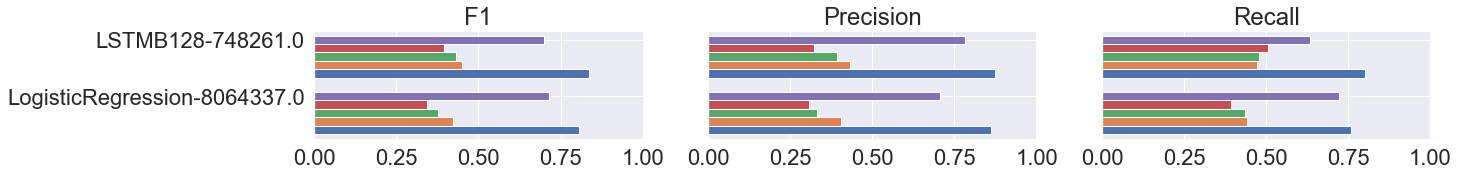

In [8]:
# combine our best LSTM and LR model into one DF so the axis are aligned in our bar graphs
cr_df = report_lstmb128_dr0_rdr20_batch32[report_lstmb128_dr0_rdr20_batch32.eval_metric == report_lstmb128_dr0_rdr20_batch32.eval_metric.max()]. \
                         append(report_lr[report_lr.eval_metric == report_lr.eval_metric.max()], ignore_index = True)
cr_df["display_name"] = cr_df.apply(lambda x: f"{x.model_name}-{str(x.train_examples)}", axis = 1)


print("Best Logistic Regression Model vs Best LSTM")
pu.plot_score_histograms(cr_df, 
                         version=2, 
                         label="display_name")


### Classification Report for LSTMB With 128 Cells

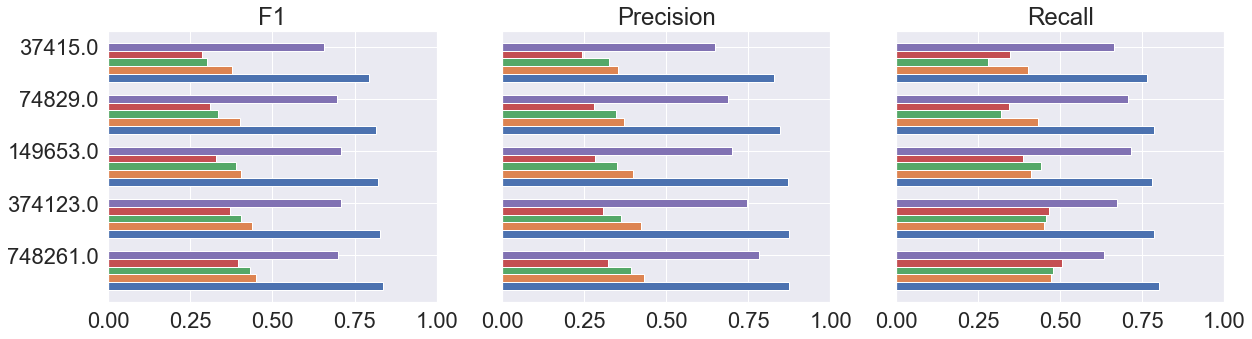

In [9]:
pu.plot_score_histograms(report_lstmb128_dr0_rdr20_batch32, 
                         version=2, 
                         label="train_examples")

# Compare 500k Sample Results

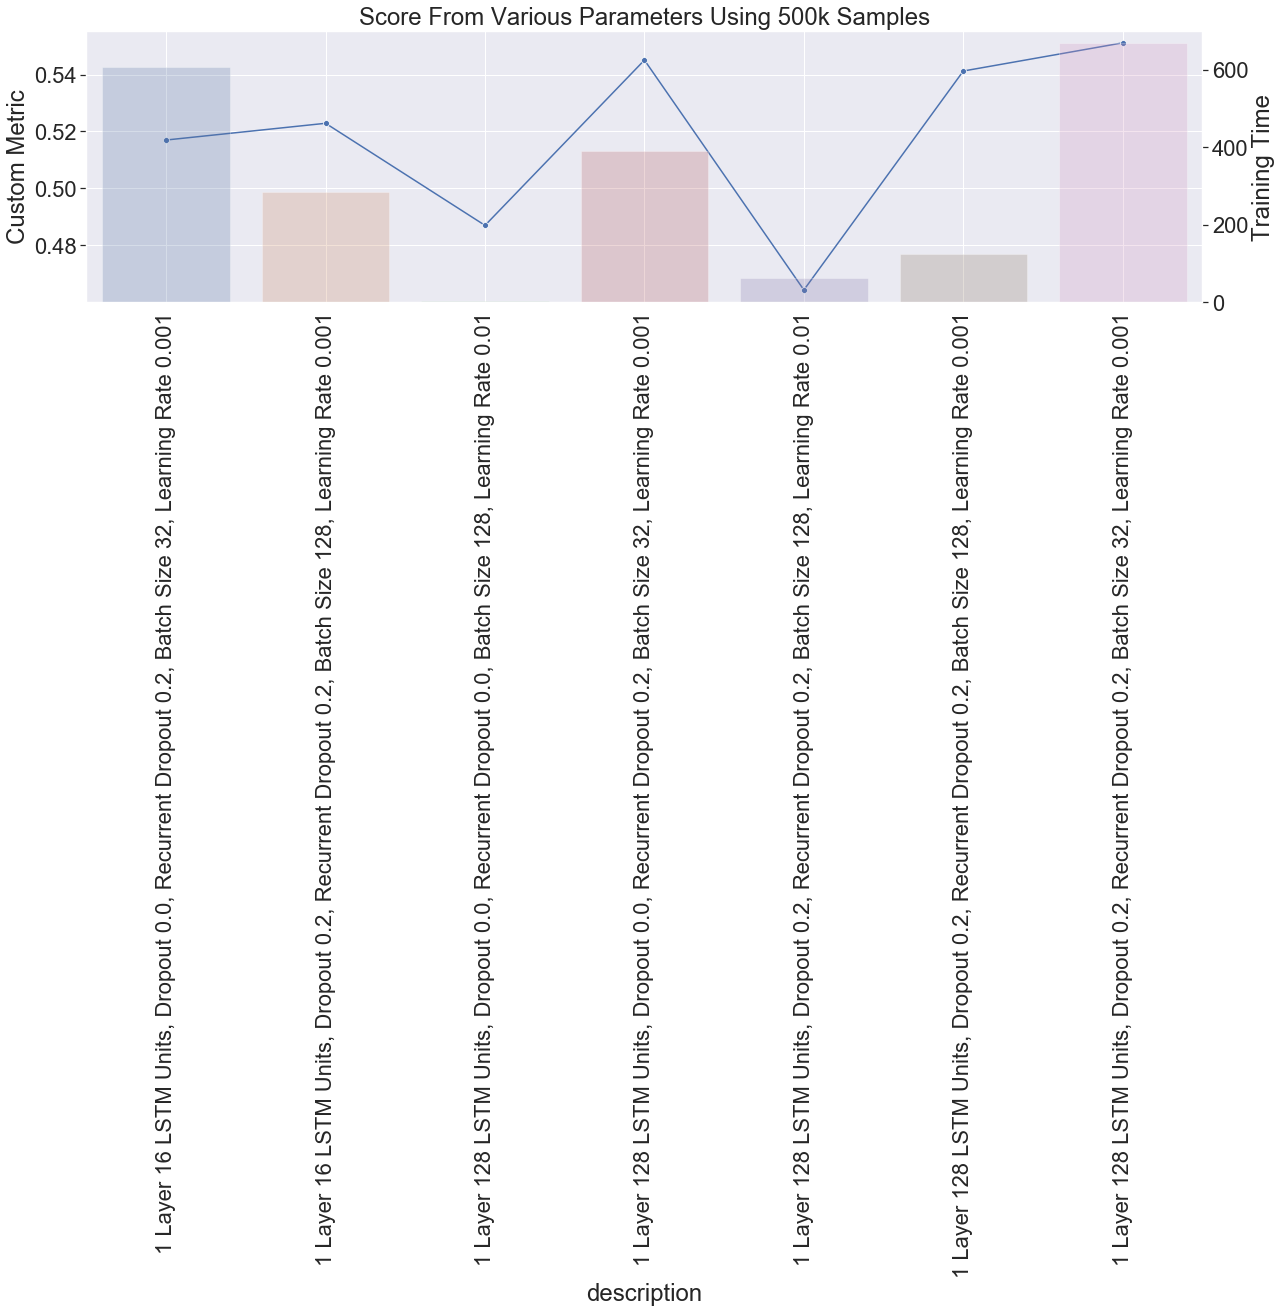

In [30]:
pd.set_option('display.max_colwidth', 150)

report_500k = report_lstmb16_2.append(report_lstmb16_dr20_rdr20_batch128, ignore_index = True). \
                                append(report_lstmb128_dr0_rdr0_batch128, ignore_index = True). \
                                append(report_lstmb128_dr0_rdr20_batch32, ignore_index = True). \
                                append(report_lstmb128_dr20_rdr20_batch128_lr01, ignore_index = True). \
                                append(report_lstmb128_dr20_rdr20_batch128_lr001, ignore_index = True). \
                                append(report_lstmb128_dr20_rdr20_batch32_lr001, ignore_index = True)
# keep only 500k total examples results
report_500k = report_500k[report_500k.train_examples == 374123]
report_500k[["model_name", "description", "eval_metric", "train_time_min", "train_examples"]]

f, a = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(data=report_500k, x="description", y="eval_metric", marker="o", sort = False)
_ = plt.xticks(rotation=90)
# _ = plt.xlabel("Training Samples")
_ = plt.ylabel("Custom Metric")
_ = plt.title("Score From Various Parameters Using 500k Samples")

a2 = a.twinx()
a2.grid(False)


_ = sns.barplot(data = report_500k, x = "description", y = "train_time_min", alpha = 0.25, ax = a2)
_ = a2.set_ylabel("Training Time")



# LSTM Hyperparameter Tuning Based on 50k Samples

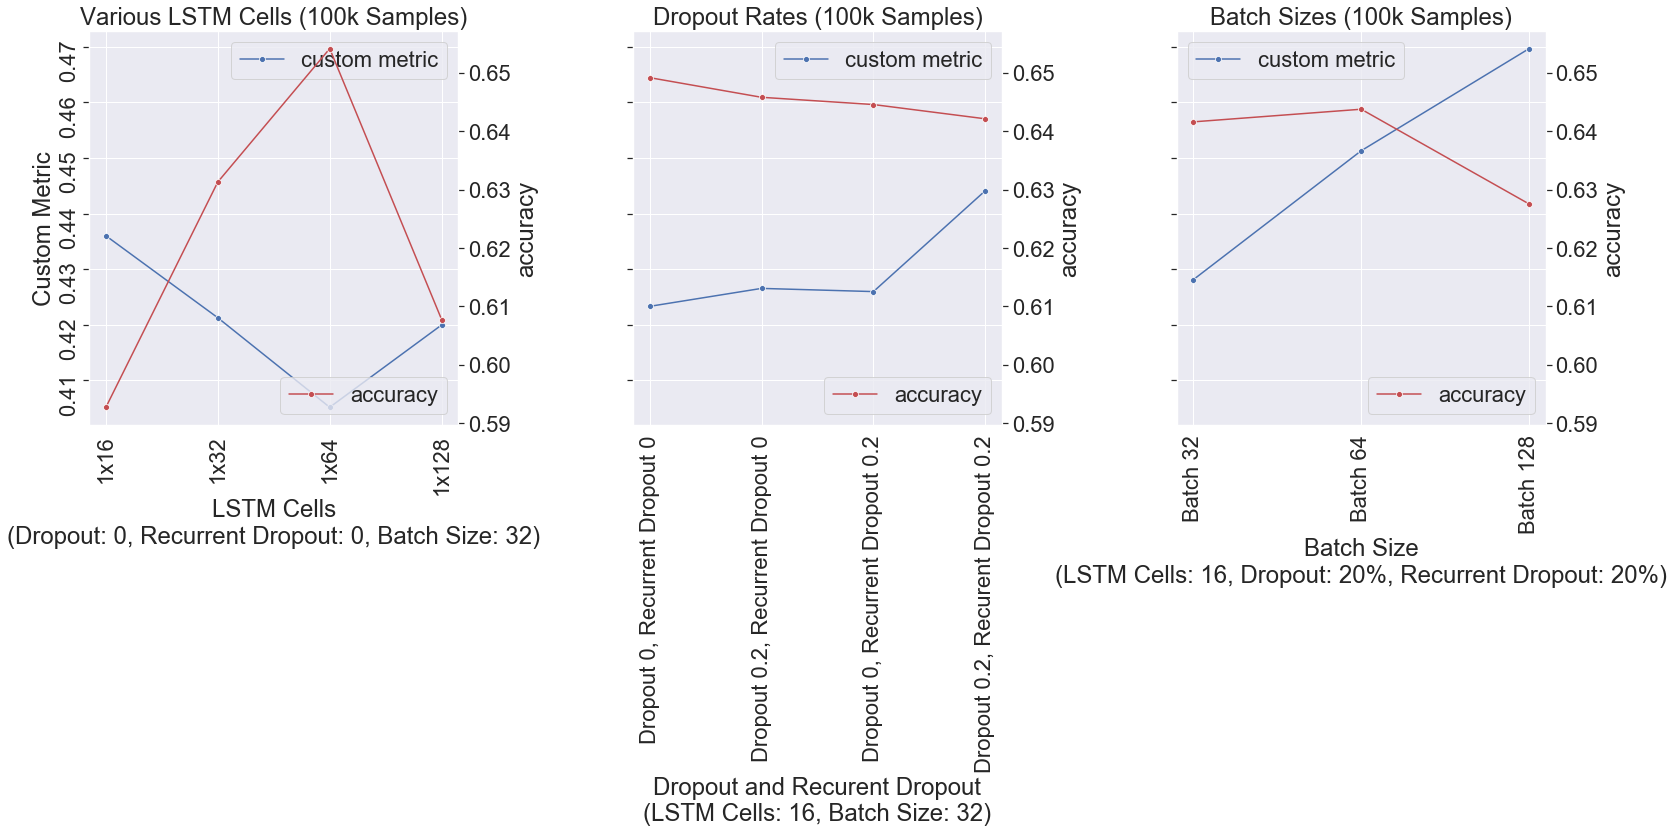

In [11]:
# get baseline for our tests - 100k samples (74829 train examples)
report_lstmb128_baseline = report_lstmb128_dr0_rdr20_batch32[(report_lstmb128_dr0_rdr20_batch32.train_examples == 74829)]

f, a = plt.subplots(1, 3, figsize=(25, 10), sharey=True)
f.tight_layout(pad=6.0)


#################### Graph Cell

report_cell_tuning = pd.read_csv(f'{REPORT_DIR}/LSTM-cell-tuning-report.csv', quotechar="'")
report_cell_tuning = ru.convert_dnn_report_format(report_cell_tuning)
report_cell_tuning["eval_metric"] = report_cell_tuning.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))
report_cell_tuning


graph = sns.lineplot(data=report_cell_tuning, x="architecture", y="eval_metric", marker="o", label="custom metric", sort=False, ax=a[0])
_ = a[0].set_ylabel("Custom Metric")
_ = a[0].set_xlabel("LSTM Cells\n(Dropout: 0, Recurrent Dropout: 0, Batch Size: 32)")


_ = a[0].tick_params(labelrotation=90)
_ = a[0].set_title("Various LSTM Cells (100k Samples)")

# _ = a.axhline(report_lstmb128_baseline.eval_metric.values[0], linestyle="--", color="r", label="baseline")

a1 = a[0].twinx()
graph = sns.lineplot(data=report_cell_tuning, x="architecture", y="accuracy", marker="o", label="accuracy", sort=False, color="r", ax=a1)
_ = a1.grid(False)
_ = plt.legend(loc='lower right')


#################### Graph Dropout

report_dropout_tuning = pd.read_csv(f'{REPORT_DIR}/LSTM-dropout-tuning-report.csv', quotechar="'")
report_dropout_tuning = ru.convert_dnn_report_format(report_dropout_tuning)
report_dropout_tuning["eval_metric"] = report_dropout_tuning.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))
report_dropout_tuning


graph = sns.lineplot(data=report_dropout_tuning, x="description", y="eval_metric", marker="o", label="custom metric", sort=False, ax=a[1])
_ = a[1].set_ylabel("Custom Metric")
_ = a[1].set_xlabel("Dropout and Recurent Dropout\n(LSTM Cells: 16, Batch Size: 32)")


# _ = plt.xticks(rotation=90)
_ = a[1].tick_params(labelrotation=90)
_ = a[1].set_title("Dropout Rates (100k Samples)")

a2 = a[1].twinx()
# align secondary y axes (accuracy)
_ = a1.get_shared_y_axes().join(a1, a2)

graph = sns.lineplot(data=report_dropout_tuning, x="description", y="accuracy", marker="o", label="accuracy", sort=False, color="r", ax=a2)
_ = a2.grid(False)
_ = plt.legend(loc='lower right')


#################### Graph Batch Sizes

report_batch_tuning = pd.read_csv(f'{REPORT_DIR}/LSTM-batch-tuning-report.csv', quotechar="'")
report_batch_tuning = ru.convert_dnn_report_format(report_batch_tuning)
report_batch_tuning["eval_metric"] = report_batch_tuning.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))
report_batch_tuning


graph = sns.lineplot(data=report_batch_tuning, x="description", y="eval_metric", marker="o", label="custom metric", sort=False, ax=a[2])
_ = a[2].set_ylabel("Custom Metric")
_ = a[2].set_xlabel("Batch Size\n(LSTM Cells: 16, Dropout: 20%, Recurrent Dropout: 20%)")

# _ = plt.xticks(rotation=90)
_ = a[2].tick_params(labelrotation=90)
_ = a[2].set_title("Batch Sizes (100k Samples)")

a3 = a[2].twinx()
# align secondary y axes (accuracy)
_ = a2.get_shared_y_axes().join(a2, a3)

graph = sns.lineplot(data=report_batch_tuning, x="description", y="accuracy", marker="o", label="accuracy", sort=False, color="r", ax=a3)
_ = a3.grid(False)
_ = plt.legend(loc='lower right')

